In [1]:
import json
import time
import datetime
import requests
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.dates as mdates

In [2]:
with open("data/pump_n_dump_events/pump_n_dump_events_from_USENIX_paper.json") as f:
    json_obj = json.load(f)

In [3]:
json_arr = json_obj['x']['data']

In [4]:
len(json_arr)

660

In [5]:
json_arr[0]['text']

['2019-02-08 16:30:43<br>SUB pumped by Crypto Market Signalz<br>3-hour open: 1.21e-05 BTC<br>3-hour high: 1.298e-05 BTC<br>pump gain: 7.27%',
 '2019-02-08 16:30:43<br>SUB pumped by Crypto Market Signalz<br>3-hour open: 1.21e-05 BTC<br>3-hour high: 1.298e-05 BTC<br>pump gain: 7.27%']

In [6]:
for data in json_arr:
    if data['text'][0] != data['text'][1]:
        print(data['text'])

In [7]:
events = list(map(lambda x: x['text'][0], json_arr))

In [8]:
len(events)

660

In [9]:
events[1]

'2019-02-08 16:30:43<br>SUB dumped by Crypto Market Signalz<br>3-hour high: 1.298e-05 BTC<br>3-hour close: 1.21e-05 BTC<br>dump loss: -6.78%'

In [10]:
class PumpDumpEvent():
    def __init__(self):
        self.coin_name = None
        self.datetime = None
        self.channel = None
        self.open_price = None
        self.close_price = None
        self.high_price = None
        self.pump_gain_perct = None
        self.dump_loss_perct = None
        
    def read_from_text(self, texts):
        pump_text = texts[0]
        dump_text = texts[1]
        
        parts = pump_text.split("<br>", 1)
        self.datetime = datetime.datetime.strptime(parts[0], "%Y-%m-%d %H:%M:%S")
        second_parts = parts[1].split(" pumped by ")
        self.coin_name = second_parts[0]
        third_parts = second_parts[1].split('<br>', 1)
        self.channel = third_parts[0]
        fourth_parts= third_parts[1].split('<br>')
        self.open_price = float(fourth_parts[0][len("3-hour open: "):-len(" BTC")])
        self.high_price = float(fourth_parts[1][len("3-hour high: "):-len(" BTC")])
        self.pump_gain_perct = float(fourth_parts[2][len("pump gain: "):-len("%")])  
        
        dump_parts = dump_text.split("<br>")
        self.close_price = float(dump_parts[3][len("3-hour close: "):-len(" BTC")])
        self.dump_loss_perct = float(dump_parts[4][len("dump loss: "):-len("%")])
        
    def print(self):
        print(
            "Coin name: " + self.coin_name \
             + " Datetime: " + str(self.datetime) \
             + " Channel: " + self.channel \
             + " Open price: " + str(self.open_price) \
             + " Close price: " + str(self.close_price) \
             + " High price: " + str(self.high_price) \
             + " Pump gain percentage: " + str(self.pump_gain_perct) \
             + " Dump loss percentage: " + str(self.dump_loss_perct)
        )

In [11]:
ex = events[0:2]
pe = PumpDumpEvent()
pe.read_from_text(ex)
pe.print()

Coin name: SUB Datetime: 2019-02-08 16:30:43 Channel: Crypto Market Signalz Open price: 1.21e-05 Close price: 1.21e-05 High price: 1.298e-05 Pump gain percentage: 7.27 Dump loss percentage: -6.78


In [12]:
pump_n_dumps = []

i=0
while i < len(events):    
    pd = PumpDumpEvent()
    pd.read_from_text([events[i], events[i+1]])
    pump_n_dumps.append(pd)
    i += 2

In [13]:
len(pump_n_dumps)

330

In [14]:
start = datetime.datetime.strptime('2018-07-10', "%Y-%m-%d")
end = datetime.datetime.strptime('2018-07-15', "%Y-%m-%d")

In [15]:
close_t0o_7_10 = [pd for pd in pump_n_dumps if pd.datetime > start and pd.datetime < end]

In [44]:
for pd in close_t0o_7_10:
    pd.print()
    print("\n")

Coin name: OSC Datetime: 2018-07-14 19:00:08 Channel: Donald Pump Open price: 1.31e-06 Close price: 1.07e-06 High price: 2.95e-06 Pump gain percentage: 125.19 Dump loss percentage: -63.73


Coin name: BUMBA Datetime: 2018-07-13 18:30:15 Channel: Bitcoin Pump Signal ™ Open price: 7.8e-07 Close price: 7.3e-07 High price: 2.05e-06 Pump gain percentage: 162.82 Dump loss percentage: -64.39


Coin name: QBT Datetime: 2018-07-12 15:00:12 Channel: Crypto Pump Island Open price: 2e-07 Close price: 2.3e-07 High price: 3.9e-07 Pump gain percentage: 95.0 Dump loss percentage: -41.03


Coin name: FNTB Datetime: 2018-07-11 21:07:27 Channel: Pump Up Open price: 2.258e-05 Close price: 2.869e-05 High price: 2.869e-05 Pump gain percentage: 27.06 Dump loss percentage: 0.0


Coin name: BUBO Datetime: 2018-07-10 19:00:08 Channel: Donald Pump Open price: 3.26e-06 Close price: 2.54e-06 High price: 7.9e-06 Pump gain percentage: 142.33 Dump loss percentage: -67.85




In [17]:
import math
coins_set = set()
channels_set = set()
max_gain = 0.0
min_loss = 0.0
earliest_event = datetime.datetime.now()
latest_event = datetime.datetime.now() - datetime.timedelta(days= 3*365)

for pd in pump_n_dumps:
    coins_set.add(pd.coin_name)
    channels_set.add(pd.channel)
    
    if pd.pump_gain_perct > max_gain and pd.pump_gain_perct != math.inf:
        max_gain = pd.pump_gain_perct
        max_gain_coin_name = pd.coin_name
        
    if pd.dump_loss_perct < min_loss:
        min_loss = pd.dump_loss_perct
        
    if pd.datetime < earliest_event:
        earliest_event = pd.datetime
        
    if pd.datetime > latest_event:
        latest_event = pd.datetime
        
print(len(events), "pump and dump events")
print(len(coins_set), "unique coins")
print(len(channels_set), "unique channels")
print("Max gain " + str(max_gain) + "%")
print("Min loss " + str(min_loss) + "%")
print("Earliest event:", earliest_event)
print("Latest event:", latest_event)


660 pump and dump events
188 unique coins
79 unique channels
Max gain 874.19%
Min loss -96.61%
Earliest event: 2018-06-18 17:59:05
Latest event: 2019-02-08 16:30:43


In [18]:
max_gain_coin_name

'CL'

In [19]:
gains = list(map(lambda x: x.pump_gain_perct, pump_n_dumps))

In [20]:
len(gains)

330

In [21]:
channels_set

{'BIG PUMP SIGNAL',
 'BTTM ®',
 'Big Crypto Pump',
 'Big Pump Signal',
 'Big Pump Signal®',
 'Big Pump channel',
 'Big signal',
 'BigPumpGroup.com',
 'Biggest Pumps',
 'Binance Profit Signal',
 'Bitcoin Pump Group',
 'Bitcoin Pump Signal ™',
 'Bitmex Pro Signals',
 'Bomba bitcoin "cryptopia"',
 'CAMP(Crypto Analysis & Market Prediction)',
 'CRYPTO BLACK 🇰🇷',
 'Central Pumps',
 'Crypto Bulls Pump ®🥇',
 'Crypto Coins (Ƀ)',
 'Crypto Experts Signal®',
 'Crypto Market Signalz',
 'Crypto Mega Pumps Yobit',
 'Crypto Pump Island',
 'Crypto Pumpers',
 'Crypto Rocket ®',
 'Crypto Signals & Pumps',
 'Crypto Vip signal™',
 'Crypto Whales™',
 'Crypto trading. ™',
 'CryptoMoon Pumps',
 'DA PUMP',
 'Donald Pump',
 'Dynamic Signals',
 'Inner Signals Circle - BITTREX / UPBIT (비트렉스,업비트)',
 'John McAfee Yobit Pump',
 'Kênh cập nhật chiến lược giao dịch alt coin',
 'LEAK Signal',
 'MassivePump',
 'McAfee Alt Signals™',
 'Mega Pump Group',
 'Mega Pumps',
 'Moon Pump™',
 'OFFICIAL SIGNAL EXPERT®',
 'OSNOVA 

In [43]:
pump_n_dumps

In [45]:
channels_cnt_dict = dict()

for pd in pump_n_dumps:
    ch = pd.channel
    if ch in channels_cnt_dict.keys():
        channels_cnt_dict[ch] += 1
    else:
        channels_cnt_dict[ch] = 1

In [37]:
channels_dict = dict()

for pd in pump_n_dumps:
    ch = pd.channel
    if ch in channels_dict.keys():
        channels_dict[ch].append(pd)
    else:
        channels_dict[ch] = [pd]

In [38]:
import collections
import operator


In [46]:
channels_cnt_dict

{'Crypto Market Signalz': 1,
 'Bitcoin Pump Group': 7,
 '🚀Ultra Pumps™': 5,
 'Crypto Pumpers': 3,
 'Trading Crypto Coach®': 1,
 'Biggest Pumps': 1,
 'Palm Venice Beach': 8,
 'Whales Crypto Guide': 6,
 'Mega Pump Group': 10,
 'Crypto trading. ™': 7,
 'Yobit Pumping Crazy Community™': 10,
 'Optimus Pump': 4,
 'Crypto Experts Signal®': 1,
 '💰Crypto Free Signals💰': 3,
 '©Pumpin®Time™': 2,
 'Moon Pump™': 1,
 'Crypto Pump Island': 45,
 'Binance Profit Signal': 6,
 'Official McAfee Pump Signals™': 1,
 'DA PUMP': 1,
 'BTTM ®': 2,
 '®Crypto Guru Bittrex Signals': 2,
 'u': 4,
 'Crypto Coins (Ƀ)': 5,
 'CAMP(Crypto Analysis & Market Prediction)': 9,
 'Big Pump channel': 2,
 'Donald Pump': 17,
 'Big Pump Signal®': 6,
 'Kênh cập nhật chiến lược giao dịch alt coin': 1,
 'Off': 6,
 'Super Pumps & Signal Kings': 14,
 'Signals Lion': 9,
 'Crypto Vip signal™': 1,
 'قناة احساسيس ومشاعر': 2,
 'Crypto Rocket ®': 4,
 'US pump signals': 1,
 'LEAK Signal': 2,
 '🚨 Cryptopia Signal 🚨': 4,
 'Mega Pumps': 1,
 'Roc

In [47]:
sorted_x = sorted(channels_cnt_dict.items(), key=operator.itemgetter(1))

In [48]:
len(sorted_x)

79

In [49]:
len(pump_n_dumps)

330

In [50]:
sorted_x

[('Crypto Market Signalz', 1),
 ('Trading Crypto Coach®', 1),
 ('Biggest Pumps', 1),
 ('Crypto Experts Signal®', 1),
 ('Moon Pump™', 1),
 ('Official McAfee Pump Signals™', 1),
 ('DA PUMP', 1),
 ('Kênh cập nhật chiến lược giao dịch alt coin', 1),
 ('Crypto Vip signal™', 1),
 ('US pump signals', 1),
 ('Mega Pumps', 1),
 ('BigPumpGroup.com', 1),
 ('OSNOVA PUMP', 1),
 ('🌟Super Pump Bros🌟', 1),
 ('CRYPTO BLACK 🇰🇷', 1),
 ('Signal Plug 📊🔌', 1),
 ('Inner Signals Circle - BITTREX / UPBIT (비트렉스,업비트)', 1),
 ('John McAfee Yobit Pump', 1),
 ('🚀DUTCH CRYPTO PUMPS!🚀', 1),
 ('Dynamic Signals', 1),
 ('🌐 YoBit Pump Team 🌐', 1),
 ('Signalsgram', 1),
 ('Big Crypto Pump', 1),
 ('Pump Signals', 1),
 ('PUMP OFFICIAL CRYPTO', 1),
 ('OFFICIAL SIGNAL EXPERT®', 1),
 ('BIG PUMP SIGNAL', 1),
 ('Crypto Mega Pumps Yobit', 1),
 ('Pump Up', 1),
 ('Bitmex Pro Signals', 1),
 ('🔥 PumpMyWallet 🔥', 1),
 ('©Pumpin®Time™', 2),
 ('BTTM ®', 2),
 ('®Crypto Guru Bittrex Signals', 2),
 ('Big Pump channel', 2),
 ('قناة احساسيس ومش

In [132]:
sec_most_Pop_Ch_pum_n_dumps = [p for p in pump_n_dumps if p.channel == 'MassivePump']

In [51]:
most_Pop_Ch_pum_n_dumps = [p for p in pump_n_dumps if p.channel == 'Crypto Pump Island']

In [144]:
for p in sec_most_Pop_Ch_pum_n_dumps:
    p.print()
    print("\n")

Coin name: ALIS Datetime: 2018-10-27 17:01:09 Channel: MassivePump Open price: 9.17e-06 Close price: 8.75e-06 High price: 1.25e-05 Pump gain percentage: 36.31 Dump loss percentage: -30.0


Coin name: FRN Datetime: 2018-10-05 17:00:27 Channel: MassivePump Open price: 8.3e-07 Close price: 7.7e-07 High price: 1.8e-06 Pump gain percentage: 116.87 Dump loss percentage: -57.22


Coin name: FRN Datetime: 2018-10-05 17:00:22 Channel: MassivePump Open price: 8.3e-07 Close price: 7.7e-07 High price: 1.8e-06 Pump gain percentage: 116.87 Dump loss percentage: -57.22


Coin name: XPTX Datetime: 2018-09-29 17:00:16 Channel: MassivePump Open price: 3.7e-05 Close price: 4.108e-05 High price: 9e-05 Pump gain percentage: 143.24 Dump loss percentage: -54.36


Coin name: FIRE Datetime: 2018-09-28 17:00:26 Channel: MassivePump Open price: 8.9e-05 Close price: 7.5e-05 High price: 0.0001894 Pump gain percentage: 112.81 Dump loss percentage: -60.4


Coin name: XPRO Datetime: 2018-09-27 17:00:00 Channel: Massi

In [140]:
sec_most_Pop_Ch_pum_n_dumps.sort(key=lambda x:x.datetime, reverse=True)

In [139]:
most_Pop_Ch_pum_n_dumps.sort(key=lambda x:x.datetime, reverse=True)

In [153]:
start = datetime.datetime.strptime('2018-08-01', "%Y-%m-%d").date()
end = datetime.datetime.strptime('2018-10-31', "%Y-%m-%d").date()

In [154]:
sec_short_sorted_ts = {k for k in sec_most_Pop_Ch_pum_n_dumps if k.datetime.date()> start and k.datetime.date() < end}

In [155]:
sec_most_Pop_Ch_pum_n_dumps

In [156]:
sec_short_sorted_ts

{<__main__.PumpDumpEvent at 0x7fa4696afd10>,
 <__main__.PumpDumpEvent at 0x7fa4696cbb90>}

In [64]:
short_sorted_ts = {k for k in most_Pop_Ch_pum_n_dumps if k.datetime.date()> start and k.datetime.date() < end}

In [136]:
for p in sec_short_sorted_ts:
    p.print()
    print("\n")

In [157]:
delta = end - start

In [111]:
delta

datetime.timedelta(days=31)

In [112]:
from datetime import date, timedelta


In [ ]:
pump_gain_perct

In [158]:
sec_cnt_dict = dict()

for pd in sec_short_sorted_ts:
    date = pd.datetime.date()
    sec_cnt_dict[date] = pd.pump_gain_perct

In [120]:
cnt_dict = dict()

for pd in short_sorted_ts:
    date = pd.datetime.date()
    cnt_dict[date] = pd.pump_gain_perct

In [121]:
cnt_dict

{datetime.date(2018, 7, 31): 100.0,
 datetime.date(2018, 7, 21): 119.23,
 datetime.date(2018, 6, 26): 82.61,
 datetime.date(2018, 8, 10): 194.44,
 datetime.date(2018, 8, 27): 135.71,
 datetime.date(2018, 7, 9): 88.57,
 datetime.date(2018, 8, 13): 188.0,
 datetime.date(2018, 7, 15): 125.0,
 datetime.date(2018, 7, 18): 84.21,
 datetime.date(2018, 7, 28): 90.48,
 datetime.date(2018, 7, 4): 143.75,
 datetime.date(2018, 6, 23): 102.78,
 datetime.date(2018, 7, 12): 95.0,
 datetime.date(2018, 8, 16): 245.45,
 datetime.date(2018, 8, 30): 133.33,
 datetime.date(2018, 8, 7): 185.71,
 datetime.date(2018, 7, 25): 75.0,
 datetime.date(2018, 6, 30): 104.76,
 datetime.date(2018, 6, 20): 92.5}

In [159]:
sec_cnt_dict_1 = dict()
for i in range(delta.days + 1):
    day = start + timedelta(days=i)
    if day in sec_cnt_dict:
        sec_cnt_dict_1[day] = sec_cnt_dict[day]
    else:
        sec_cnt_dict_1[day] = 0

In [126]:
cnt_dict_1 = dict()
for i in range(delta.days + 1):
    day = start + timedelta(days=i)
    if day in cnt_dict:
        cnt_dict_1[day] = cnt_dict[day]
    else:
        cnt_dict_1[day] = 0

In [127]:
cnt_dict_1

{datetime.date(2018, 7, 1): 0,
 datetime.date(2018, 7, 2): 0,
 datetime.date(2018, 7, 3): 0,
 datetime.date(2018, 7, 4): 143.75,
 datetime.date(2018, 7, 5): 0,
 datetime.date(2018, 7, 6): 0,
 datetime.date(2018, 7, 7): 0,
 datetime.date(2018, 7, 8): 0,
 datetime.date(2018, 7, 9): 88.57,
 datetime.date(2018, 7, 10): 0,
 datetime.date(2018, 7, 11): 0,
 datetime.date(2018, 7, 12): 95.0,
 datetime.date(2018, 7, 13): 0,
 datetime.date(2018, 7, 14): 0,
 datetime.date(2018, 7, 15): 125.0,
 datetime.date(2018, 7, 16): 0,
 datetime.date(2018, 7, 17): 0,
 datetime.date(2018, 7, 18): 84.21,
 datetime.date(2018, 7, 19): 0,
 datetime.date(2018, 7, 20): 0,
 datetime.date(2018, 7, 21): 119.23,
 datetime.date(2018, 7, 22): 0,
 datetime.date(2018, 7, 23): 0,
 datetime.date(2018, 7, 24): 0,
 datetime.date(2018, 7, 25): 75.0,
 datetime.date(2018, 7, 26): 0,
 datetime.date(2018, 7, 27): 0,
 datetime.date(2018, 7, 28): 90.48,
 datetime.date(2018, 7, 29): 0,
 datetime.date(2018, 7, 30): 0,
 datetime.date(20

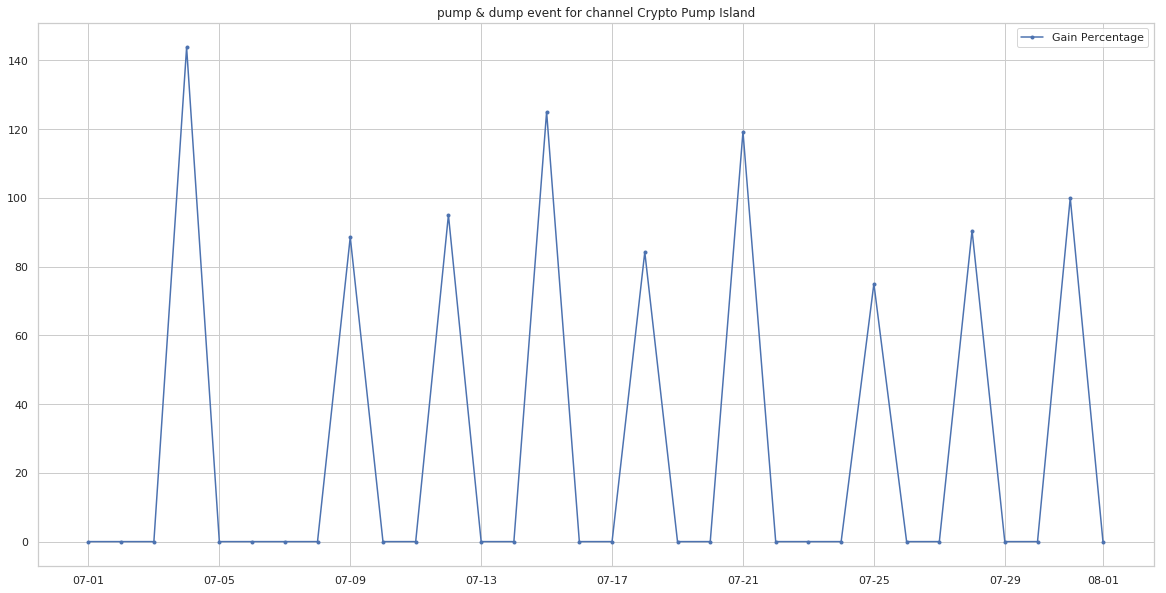

In [131]:


    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(cnt_dict_1.keys(), cnt_dict_1.values(), '.-', label="Gain Percentage")
ax.xaxis.set_major_formatter(format_xdata)
ax.xaxis_date()
#ax.set_ylim(ymin=0)
plt.title("pump & dump event for channel Crypto Pump Island")
format_xdata = mdates.DateFormatter('%m-%d')     
plt.legend()
plt.show()

In [ ]:
sec_cnt_dict_1

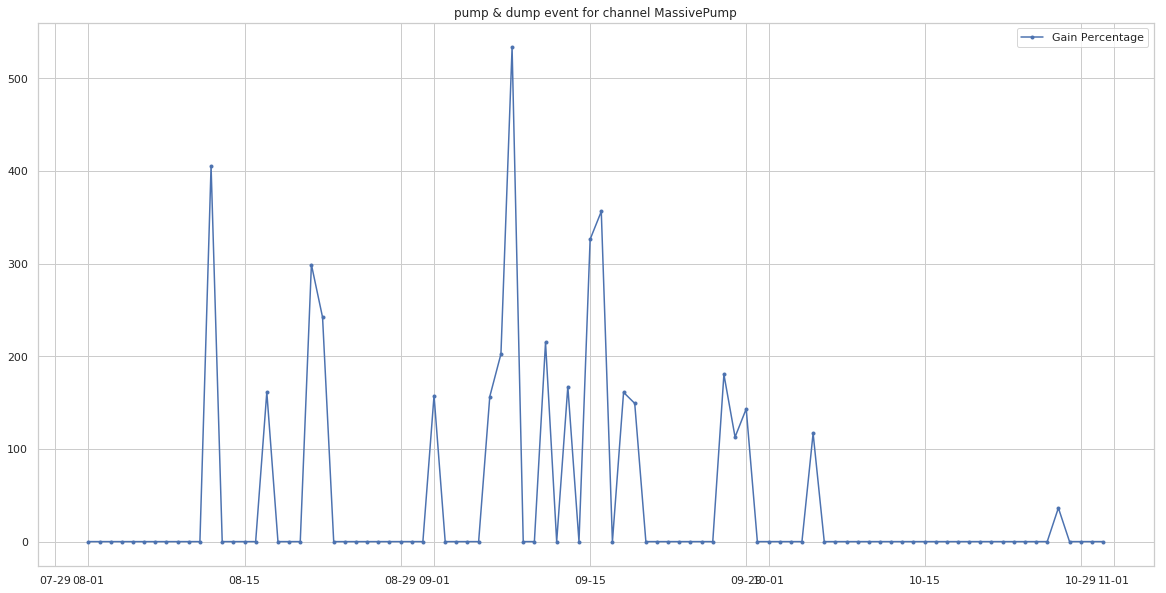

In [160]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(sec_cnt_dict_1.keys(), sec_cnt_dict_1.values(), '.-', label="Gain Percentage")
ax.xaxis.set_major_formatter(format_xdata)
ax.xaxis_date()
#ax.set_ylim(ymin=0)
plt.title("pump & dump event for channel MassivePump")
format_xdata = mdates.DateFormatter('%m-%d')     
plt.legend()
plt.show()